# Préparation

## Librairies

Libraries are used as a collection of pre-defined commands that can – once imported – be used throughout the notebook.

Importer ces librairies qui auront préalablement ajoutées à l'environnement de travail activé (soit dans un environnement local, soit dans le document _environment.yml_ dans Binder).

In [1]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv

In [2]:
# https://github.com/drgrib/dotmap
from dotmap import DotMap

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# Non utilisées pour l'instant dans ce carnet
# import jdcal as jd
# import datetime


## Fonction locales

In [4]:
# Fonction de nettoyage des chaînes de caractères
def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a    

In [5]:
###  Fonction qui élimine les doubons dans la légende
##  https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

# Préparation des données à analyser

## Ourvir et inspecter le fichier

In this section, the data are inspected a first time. Here, we import the downloaded Geovistory output.

Ce fichier contient le résultat d'une requête effectuée dans Geovistory, une table dans le domaine Analysis, ayant le même nom, effectuée à la date indiquée dans le nom du fichier. Si on souhaite utiliser un nouveau fichier, contenant de nouvelles données, il faut le télécharger depuis Geovistory vers le dossier *geovistory_query_exports* et indiquer l'adresse correcte dans la cellule suivante

In [6]:
file = 'geovistory_query_exports/aq_stato_civile_20210831.json'

In [7]:
### Ouvrir le fichier et le mettre dans la variable *data* sous forme de dictionnaire Python
with open(file) as json_file:
    data = json.load(json_file)
print(type(data), '\n-----')
# noms des objets racine du fichier JSON
z = [print(a) for a in data]

<class 'dict'> 
-----
columns
rows


In [8]:
### Nombre de lignes dans le fichier, 
# elles correspondent aux lignes du tableau 
# résultant de la requête dans Geovistory
rows = data['rows']
len(rows)

5794

In [8]:
### Les noms des colonnes issues de la requête dans Geovistory
columns = data['columns']
pprint.pprint(columns)

{'col_0': 'Entity Preview',
 'col_1': 'Gender',
 'col_10': 'Witness date(s)',
 'col_11': 'Witness in enquiry of type',
 'col_12': 'Real identity',
 'col_13': 'Union Date',
 'col_2': 'Birth',
 'col_3': 'Occupation Date',
 'col_4': 'Occupation Type',
 'col_5': 'Origin',
 'col_6': 'Pre-matrimonial Enquiry',
 'col_7': 'Pre-matrimonial Enquiry Date',
 'col_8': 'Pre-matrimonial Enquiry Type',
 'col_9': 'Witness'}


In [ ]:
### Afficher deux lignes du tableau
# et explorer les objets qui représentent les cellules
# du tableau pour chaque colonne
[pprint.pprint(r) for r in rows[99:101]]

In [9]:
### Créer un objet DotMap afin de faciliter le travail sur le fichier JSON
dm_data = DotMap(data)

In [10]:
### Créer une variable contenant les lignes
dm_r = dm_data.rows
### L'effectif des lignes
len(dm_r)

5794

## Transformation et mise à plat des données

Il est nécessaire de disposer de données agrégées et mises à plat (en supprimant notamment les valeurs multiples pour une seule variable) afin de pouvoir effectuer les analyses.

The following procedure was applied  to create a new table:
- if multiple years existed (e.g. birth year), the average was chosen
- if multiple occupation existed, all of them were kept and separated with a “#” sign
- if multiple types of processetto existed, all of them were kept and separated with a “#” sign


Below you find an extract of this new table. This new table is automatically exported as a csv-document. You can access and download this document in your jupyter-binder. You can open it in excel (via csv-import) and also analyze it there. This might help to understand the structure of the newly created table.

In [11]:
### Persons list = pl
#   liste de personnes agrégéées et propriétés mises à plat

pl = [['id_persona','nome','anno_nascita','genere','luogo_origine','mestieri',\
       'numero_processetti','id_primo_processetto','anno_primo_processetto','tipo_primo_processetto',\
       'numero_testimonianze','id_prima_testimonianza','anno_prima_testimonianza','tipo_prima_testimonianza',\
       'date_unions']]

for r in dm_r: # [60:90]
    element = []
    # personne
    element += [r.col_0.entity.pk_entity, clean_up_str(r.col_0.entity.entity_label)]
    values = []
    # annee naissance
    for v in r.col_2['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]
        
    # genre    
    element += [r.col_1.entities[0].entity_label if r.col_1.entities else 'missing']

    # origine(s)
    element += ['#'.join([clean_up_str(p.entity_label) + '('+ str(p.pk_entity) +')' for p in r.col_5.entities])]

    # metier(s)
    element += ['#'.join([clean_up_str(p.entity_label) + '('+ str(p.pk_entity) +')' for p in r.col_4.entities])]
    # element += [clean_up_str(p.entity_label) + '('+ str(p.pk_entity) +')' for p in r.col_4.entities]
    pl.append(element)
    
    # nombre processetti + id premier processetto
    if len(r.col_6.entities) > 0:
        element += [len(r.col_6.entities)]
        element += [[v.pk_entity for v in r.col_6.entities][0]]
    else:
        element += [0]
        element += [0]
        
    # annee premier processetto
    values = []
    for v in r.col_7['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]
        
    # types premier processetto
    if len(r.col_8.entities) > 0:
        element += ['#'.join([v.entity_label for v in r.col_8.entities])]
    else:
        element += ['']
    
        
    
    # nombre testimone + id premier processetto testimone
    if len(r.col_9.entities) > 0:
        element += [len(r.col_9.entities)]
        element += [[v.pk_entity for v in r.col_9.entities][0]]
    else:
        element += [0]
        element += [0]
        
    # annee premier processetto testimone
    values = []
    for v in r.col_10['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]

    # types processetto comme contexte de témoignage
    if len(r.col_11.entities) > 0:
        element += ['#'.join([v.entity_label for v in r.col_11.entities])]
    else:
        element += ['']
        
    # Union
    values = []
    for v in r.col_13['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]
    

In [ ]:
### Inspection des données produites
pl[:3]

In [12]:
### Transformation en DataFrame 
pl_df = pd.DataFrame(pl[1:], columns=pl[0])
print('Effectif :', len(pl_df), '\n')
pl_df.head()

Effectif : 5794 



,id_persona,nome,anno_nascita,genere,luogo_origine,mestieri,numero_processetti,id_primo_processetto,anno_primo_processetto,tipo_primo_processetto,numero_testimonianze,id_prima_testimonianza,anno_prima_testimonianza,tipo_prima_testimonianza,date_unions
0,81417,Tommaso di Lorenzo Spilman (tedesco),1558.0,Maschile,Alemania(753623),,0,0,NaN,,1,739330,1592.0,Stato libero di “foresto” #Processetto atipico,NaN
1,81461,Gieremia Vais,NaN,Maschile,,,0,0,NaN,,0,0,NaN,,NaN
2,81648,"Limoletti, Domenico",NaN,Maschile,,,0,0,NaN,,0,0,NaN,,NaN
3,737969,Maestro Venere (Padova),NaN,Maschile,,,0,0,NaN,,0,0,NaN,,NaN
4,737986,Giacomo di Cristoforo Franes (da Füssen),1566.0,Maschile,Füssen(1082004),,1,739330,1592.0,Stato libero di “foresto” #Processetto atipico,0,0,NaN,,1592.0


In [ ]:
### Export vers un fichier CSV
#  Ce fichier pourra être exploré et manipulé dans un tableur, si souhaité
file_exp = 'geovistory_query_exports/demographie.csv'
pl_df.to_csv(file_exp, sep='|')

## Ajout de l'âge

Ajout d'une colonne contenant l'age des personnes au moment du processetto. Noter qu'il s'agit de moyenne en raison de la mise à plat et lissage des données opéré ci-dessus

In [13]:
pl_df['anno_primo_processetto'] = pl_df['anno_primo_processetto'].fillna(0)
pl_df['anno_prima_testimonianza'] = pl_df['anno_prima_testimonianza'].fillna(0)

In [14]:
pl_df['eta'] = pl_df['anno_primo_processetto'] + pl_df['anno_prima_testimonianza'] - pl_df['anno_nascita']
pl_df['eta'] = pl_df['eta'].fillna(0)

### Effectifs par type de processetto
The lines below list the number of processetto per type

In [16]:
### Regrouper par type de processetto
gb_pl_df = pl_df.groupby('tipo_primo_processetto').size()
gb_pl_df.sort_values(ascending = False)

tipo_primo_processetto
                                                                                    3954
Stato libero di “foresto”                                                           1567
Vedovanza                                                                            195
Stato libero di “foresto” #Processetto atipico                                        16
Stato libero di “foresto” #Stato libero di persona lungamente assente da Venezia      14
Processetto atipico                                                                   13
Stato libero di persona lungamente assente da Venezia                                 13
Vedovanza#Stato libero di “foresto”                                                   12
Vedovanza#Processetto atipico                                                          8
Processetto atipico #Stato libero di persona lungamente assente da Venezia             2
dtype: int64

### Nombre de processetti / témoignages par personne

Ces requêtes peuvent être utiliser pour vérifer les données.

The lines below examine how many of the witnesses / demanders have been part of one or several processetti.

In [17]:
### Nombre de processetti par personne
# Colonnes : effectif processetti par personne, effectif personne avec cet effectif
gb_pl_df = pl_df.groupby('numero_processetti').size()
gb_pl_df.sort_values(ascending = False)

numero_processetti
0    3952
1    1840
2       2
dtype: int64

In [18]:
### Nombre de témoignages par personne
# Colonnes : effectif témoignages par personne, effectif personne avec cet effectif
gb_pl_df = pl_df.groupby('numero_testimonianze').size()
gb_pl_df.sort_values(ascending = False)

numero_testimonianze
1    3537
0    2126
2     124
3       6
4       1
dtype: int64

In [20]:
### Nombre de processetti par personne
pl_df[pl_df['numero_processetti']==2]

,id_persona,nome,anno_nascita,genere,luogo_origine,mestieri,numero_processetti,id_primo_processetto,anno_primo_processetto,tipo_primo_processetto,numero_testimonianze,id_prima_testimonianza,anno_prima_testimonianza,tipo_prima_testimonianza,date_unions,eta
2565,1154189,"Giuseppe di Francesco detto Polenta (udinese, ...",1576.0,Maschile,Territorio di Udine(759336),calegher(757359)#cerdo(985332),2,1154425,1599.0,Stato libero di “foresto”,0,0,0.0,,NaN,23.0
4382,1511103,"Pasqualina di Giorgio (mariner), vedova di Dom...",NaN,Femminile,,,2,1511117,1628.0,Stato libero di “foresto”,0,0,0.0,,1626.0,0.0


In [152]:
### Nombre de témoignages par personne
pl_df[pl_df['numero_testimonianze']==3]

,id_persona,nome,anno_nascita,genere,luogo_origine,mestieri,numero_processetti,id_primo_processetto,anno_primo_processetto,tipo_primo_processetto,numero_testimonianze,id_prima_testimonianza,anno_prima_testimonianza,tipo_prima_testimonianza,date_unions,eta
226,764721,"Giovanni di Daniele Marconi (da Travesio, facc...",1551.0,Maschile,Travesio(764857),fachin(749039),0,0,0.0,,3,764839,1598.0,Vedovanza#Stato libero di “foresto” #Processet...,NaN,47.0
858,1036690,"Cristoforo di Tommaso Volpi (da Ranzanico, fac...",1554.0,Maschile,Ranzanico(1036748),fachin(749039),0,0,0.0,,3,1036823,1598.0,Stato libero di “foresto”,NaN,44.0
1044,1050308,Agostino di Antonio Desiderati (da Padenghe su...,1566.0,Maschile,Padenghe sul Garda(1050413),capeler(1057729),0,0,0.0,,3,1050581,1598.0,Vedovanza#Stato libero di “foresto”,NaN,32.0
1633,1091832,"Francesco di Tommaso Onger (udinese, calegher)",1566.0,Maschile,Territorio di Udine(759336),calegher(757359)#cerdo(985332),1,1092130,1599.0,Stato libero di “foresto”,3,1154425,1599.0,Stato libero di “foresto”,NaN,1632.0
2638,1159538,"Ambrogio di Faustino Vitali (da Grevo, fachin)",1556.0,Maschile,Grevo(1159494),fachin(749039),0,0,0.0,,3,1159625,1598.0,Stato libero di “foresto”,NaN,42.0
3479,1299129,"Battista di Giacomo (dal Cadore, forner)",1566.0,Maschile,Cadore(761036),forner(760716),0,0,0.0,,3,1299579,1601.0,Stato libero di “foresto”,NaN,35.0


## Nettoyage et codage des données 

Le tableau produit simplifie et uniformise les données en vue de l'analyse.

he lines below define which processetti-type is kept for each person. This is relevant for each entry with multiple processetti-types. For this, there is given a priority to the different types. This priority is the following: a) atipico, b) vedovanza, c) assente, d) libero, e) manca.

Below you find an extract of this new table.

In [54]:
### Les années sont définies en fonction des données disponibles. 
# Si la période est élargie, il faudra étentre la série

liste_annees = pd.RangeIndex(1592, 1694).to_series()
liste_annees.tail().values

array([1689, 1690, 1691, 1692, 1693])

In [55]:
##  https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
result_list = []
for l in liste_annees:  # [:2]
    for (i,row) in pl_df.iterrows():   # .iloc[:100]
        # print(l, row['anno_primo_processetto'])
        if l == row['anno_primo_processetto']:
            if 'atipico' in row['tipo_primo_processetto']:
                proc_type = 'atipico'
            elif 'Vedovanza' in row['tipo_primo_processetto']:
                proc_type = 'vedovanza'
            elif 'assente' in row['tipo_primo_processetto']:
                proc_type = 'a lungo assente'
            elif 'libero' in row['tipo_primo_processetto']:
                proc_type = 'stato libero'
            else:
                proc_type = 'manca'
            result_list.append([l, 'richiedente', proc_type, row['genere'], int(row['eta'])])

        if l == row['anno_prima_testimonianza']:
            if 'atipico' in row['tipo_prima_testimonianza']:
                proc_type = 'atipico'
            elif 'Vedovanza' in row['tipo_prima_testimonianza']:
                proc_type = 'vedovanza'
            elif 'assente' in row['tipo_prima_testimonianza']:
                proc_type = 'a lungo assente'
            elif 'libero' in row['tipo_prima_testimonianza']:
                proc_type = 'stato libero'
            else:
                proc_type = 'manca'

            result_list.append([l, 'testimone', proc_type, row['genere'], int(row['eta'])])
            
                        
            

In [56]:
print(len(result_list))
result_list[:10]

5491


[[1592, 'testimone', 'atipico', 'Maschile', 34],
 [1592, 'richiedente', 'atipico', 'Maschile', 26],
 [1592, 'richiedente', 'stato libero', 'Maschile', 25],
 [1592, 'richiedente', 'stato libero', 'Maschile', 20],
 [1592, 'richiedente', 'stato libero', 'Maschile', 26],
 [1592, 'testimone', 'atipico', 'Maschile', 34],
 [1592, 'richiedente', 'stato libero', 'Maschile', 22],
 [1592, 'richiedente', 'stato libero', 'Maschile', 32],
 [1592, 'testimone', 'stato libero', 'Maschile', 29],
 [1592, 'richiedente', 'stato libero', 'Maschile', 38]]

In [57]:
df_result_list = pd.DataFrame(result_list, columns=['anno', 'qualita_persona', 'tipo','genere','eta'])
df_result_list.iloc[1030:1040]

,anno,qualita_persona,tipo,genere,eta
1030,1596,richiedente,stato libero,Maschile,20
1031,1596,testimone,stato libero,Maschile,51
1032,1596,testimone,stato libero,Maschile,56
1033,1596,richiedente,vedovanza,Femminile,0
1034,1596,testimone,vedovanza,Maschile,40
1035,1596,testimone,vedovanza,Maschile,40
1036,1596,testimone,vedovanza,Maschile,70
1037,1596,richiedente,vedovanza,Femminile,0
1038,1596,testimone,vedovanza,Maschile,56
1039,1596,testimone,vedovanza,Maschile,50


# Analyse

## Effectifs de requérants / témoignages et distribution dans le temps

### Effectifs généraux

The lines below give insight on how many people are counted as “demanders” (richiedente), respectively as “witness” (testimone).

In [58]:
### Effectif des personnes ayant été objets d'un processetto
len(pl_df[pl_df['id_primo_processetto']>0])

1842

In [59]:
### Effectif des personnes ayant été objets d'un processetto
len(df_result_list[df_result_list['qualita_persona']=='richiedente'])

1836

In [60]:
### Effectif des personnes ayant témoigné lors d'un processetto
len(pl_df[pl_df['id_prima_testimonianza']>0])

3668

In [61]:
### Effectif des personnes ayant été objets d'un processetto
len(df_result_list[df_result_list['qualita_persona']=='testimone'])

3655

### Distribution dans le temps

Nombre de processetti par année

In [62]:
rl = df_result_list[(df_result_list['qualita_persona']=='richiedente')&(df_result_list['anno'] < 1640)].groupby('anno').size()
# rl.head()

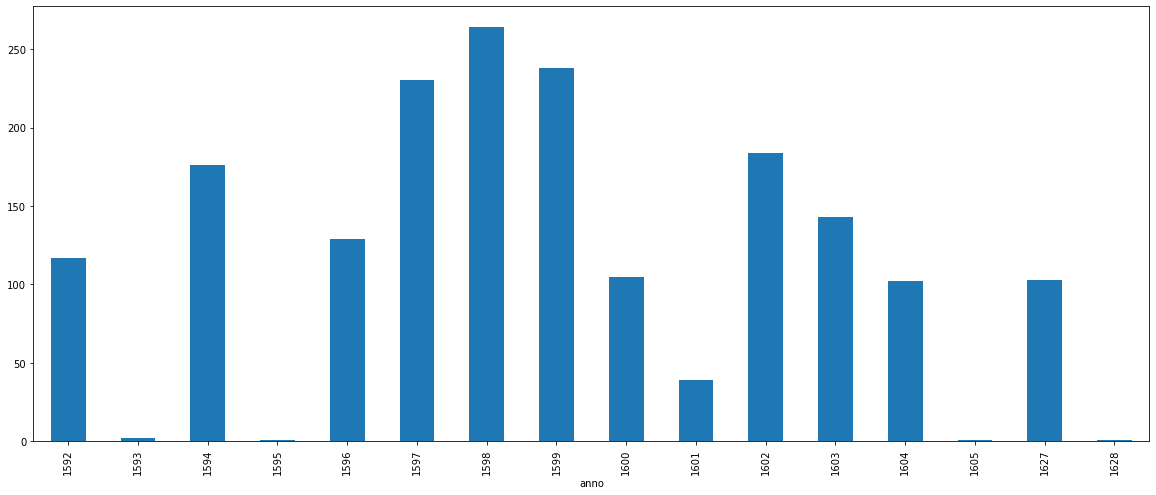

In [31]:
g = rl.plot(kind="bar", figsize=(20,8))

In [72]:
filtered_df = df_result_list[(df_result_list['genere'] != 'missing')&(df_result_list['genere'] !='Machile')\
                   & (df_result_list['anno'] < 1610) & (df_result_list['qualita_persona'] == 'richiedente')]
filtered_df.iloc[100:105]

,anno,qualita_persona,tipo,genere,eta
282,1592,richiedente,vedovanza,Maschile,0
284,1592,richiedente,stato libero,Maschile,24
287,1592,richiedente,stato libero,Maschile,22
290,1592,richiedente,stato libero,Femminile,0
293,1592,richiedente,stato libero,Maschile,20


In [73]:
### Valeurs de centralité et dispersion pour le temps
df_result_list[df_result_list['qualita_persona']=='richiedente']['anno'].describe()

count    1836.000000
mean     1600.091503
std         7.657470
min      1592.000000
25%      1597.000000
50%      1598.000000
75%      1602.000000
max      1693.000000
Name: anno, dtype: float64

## Distribution des genres

In [74]:
a = df_result_list.groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     4904
Femminile     577
missing         9
Machile         1
dtype: int64

In [78]:
### Proportion des genres dans la population
a = df_result_list[(df_result_list['genere'] != 'missing')].groupby('genere').size()
[v/sum(a.values)*100 for v in a.values]

[10.525355709595038, 0.018241517694272163, 89.45640277271069]

In [85]:
### Modalités – il y a une erreur de saisie

list(set(df_result_list['genere']))

['Femminile', 'missing', 'Machile', 'Maschile']

In [75]:
a = df_result_list[df_result_list['qualita_persona']=='richiedente'].groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     1405
Femminile     430
missing         1
dtype: int64

In [76]:
a = df_result_list[(df_result_list['qualita_persona']=='richiedente')&(df_result_list['tipo']=='stato libero')].groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     1290
Femminile     272
missing         1
dtype: int64

In [77]:
a = df_result_list[(df_result_list['qualita_persona']=='testimone')].groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     3499
Femminile     147
missing         8
Machile         1
dtype: int64

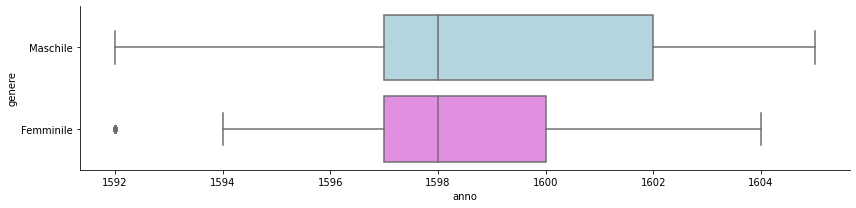

In [80]:
### https://seaborn.pydata.org/generated/seaborn.violinplot.html
ax = sns.catplot(kind="box", x="anno", y="genere", orient="h", height=3,aspect=4, 
                    data=filtered_df\
                 , palette=['lightblue','violet'])

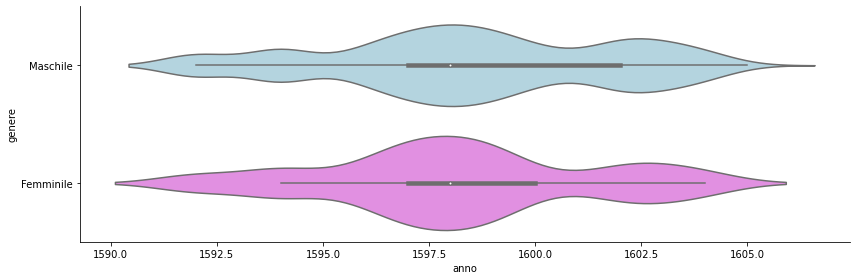

In [81]:
### https://seaborn.pydata.org/generated/seaborn.violinplot.html
ax = sns.catplot(kind="violin", x="anno", y="genere", orient="h", height=4,aspect=3, 
                    data=filtered_df\
                 , palette=['lightblue','violet'], split=True)

In [82]:
### Effectifs des hommes et des femmes
filtered_df.groupby('genere').size()

genere
Femminile     398
Maschile     1332
dtype: int64

In [83]:
genere_effectif = filtered_df['genere'].value_counts().values
m_freq = genere_effectif[0]/sum(genere_effectif)
f_freq = genere_effectif[1]/sum(genere_effectif)
m_freq, f_freq

(0.7699421965317919, 0.2300578034682081)

In [84]:
filtered_df_m = df_result_list[(df_result_list['genere'] == 'Maschile')\
                   & (df_result_list['anno'] < 1610) & (df_result_list['qualita_persona'] == 'richiedente')]
# filtered_df_m

In [45]:
filtered_df_f = df_result_list[(df_result_list['genere'] == 'Femminile')\
                   & (df_result_list['anno'] < 1610) & (df_result_list['qualita_persona'] == 'richiedente')]
# filtered_df_f

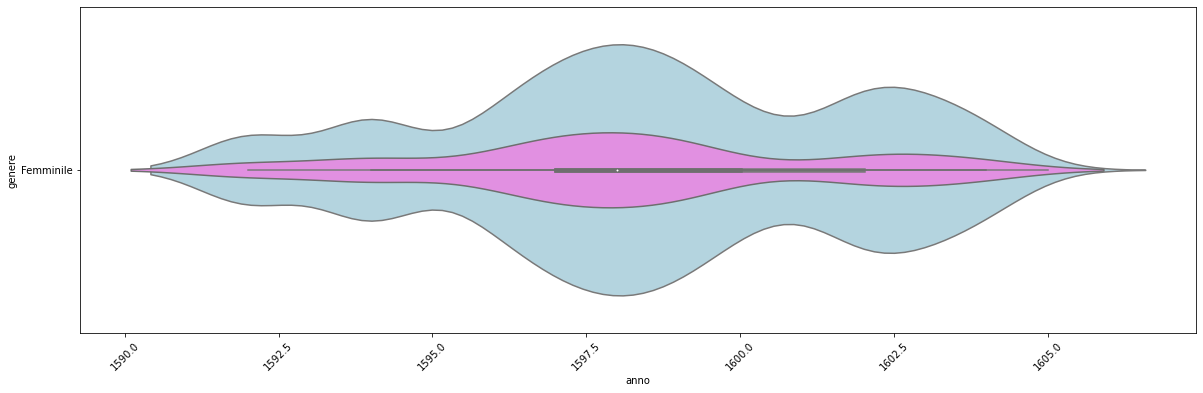

In [86]:
### Séparer et comparer les requérants hommes et femmes
##  https://stackoverflow.com/questions/39013425/multiple-stacked-bar-plot-with-pandas
## Voir aussi : https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars-with-python-pandas

fig, ax = plt.subplots(figsize=(20,6))

sns.violinplot(x="anno", y="genere", orient="h", height=4,aspect=3, width = m_freq,
                    data=filtered_df_m\
                 , color='lightblue', ax=ax, split=True)
sns.violinplot(x="anno", y="genere", orient="h", height=4,aspect=3, width = f_freq,
                    data=filtered_df_f\
                 ,ax=ax, split=True, color='violet')

plt.xticks(rotation=45)
plt.show()

In [87]:
pt = filtered_df[['anno', 'genere']].pivot_table(index='anno',columns='genere',aggfunc=len).fillna(0).astype(int) 
pt

genere,Femminile,Maschile
anno,,
1592,25,92
1593,0,2
1594,41,135
1595,0,1
1596,31,98
1597,68,162
1598,65,199
1599,67,170
1600,13,92


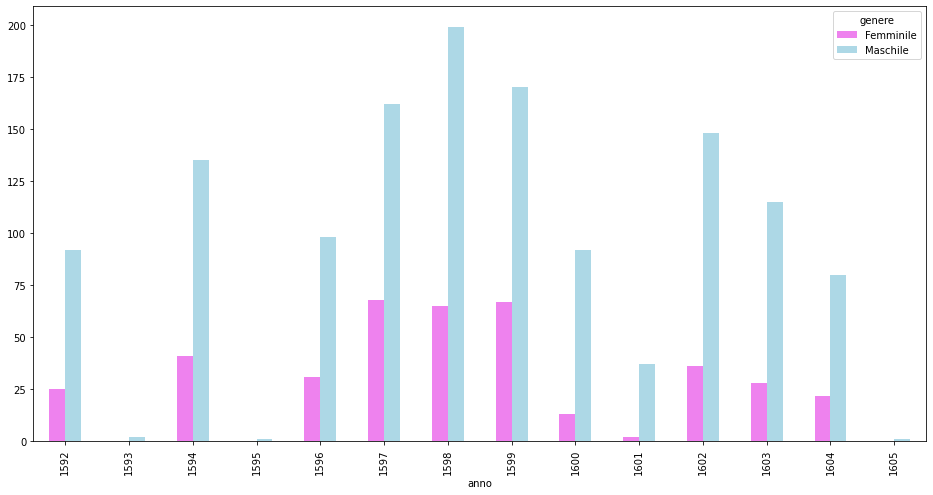

In [88]:
p = pt.plot.bar(figsize=(16,8), color=['violet','lightblue'])

In [89]:
pt_prop = pt.apply(lambda x: x*100/sum(x), axis=1)
# pt_prop

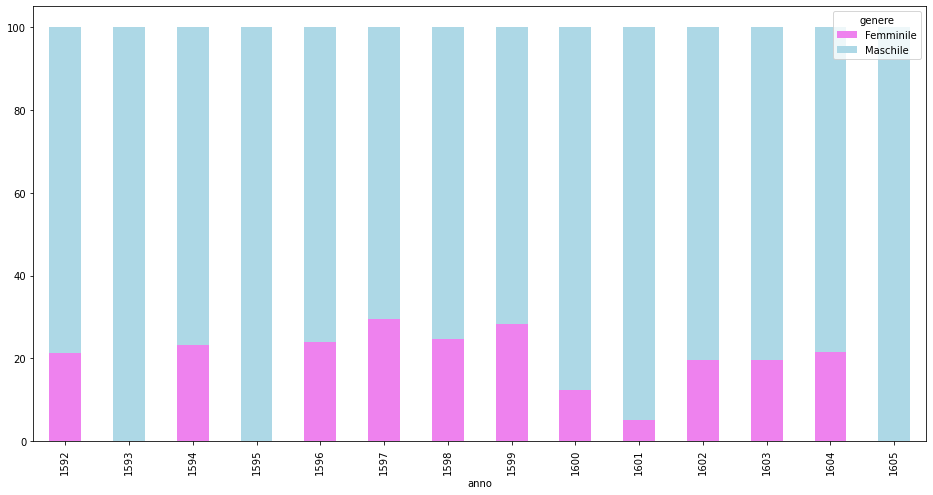

In [90]:
p = pt_prop.plot.bar(figsize=(16,8), color=['violet','lightblue'], stacked=True)

## Comparer types de processetti et genre

In [102]:
tt = filtered_df[['tipo', 'genere']].pivot_table(index='tipo',columns='genere',aggfunc=len).fillna(0).astype(int) 
tt

genere,Femminile,Maschile
tipo,,
a lungo assente,1,13
atipico,15,18
stato libero,248,1236
vedovanza,134,65


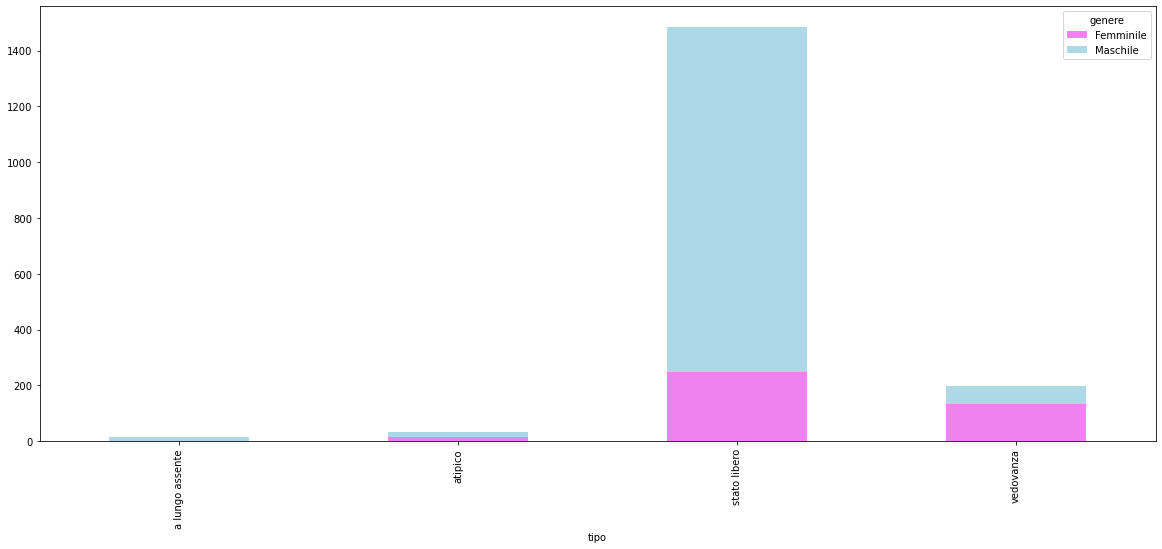

In [103]:
p = tt.plot(kind="bar", stacked="true", figsize=(20,8), color=['violet','lightblue'])

In [93]:
tt_prop = tt.apply(lambda x: x*100/sum(x), axis=1)
tt_prop

genere,Femminile,Maschile
tipo,,
a lungo assente,7.142857,92.857143
atipico,45.454545,54.545455
stato libero,16.711590,83.288410
vedovanza,67.336683,32.663317


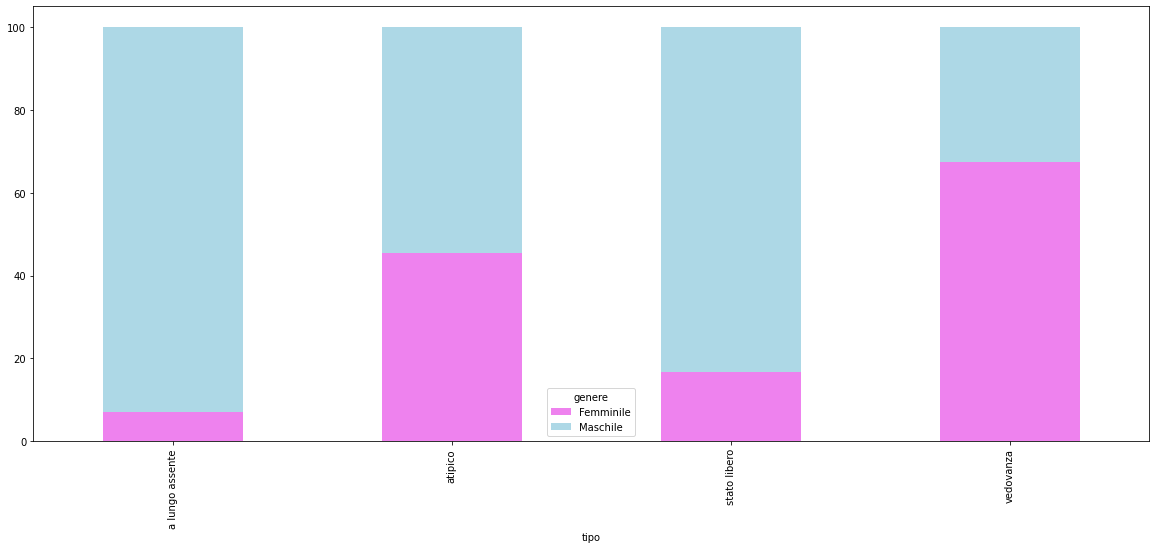

In [94]:
p = tt_prop.plot(kind="bar", stacked="true", figsize=(20,8), color=['violet','lightblue'])

### En ajoutant la dimension temporelle

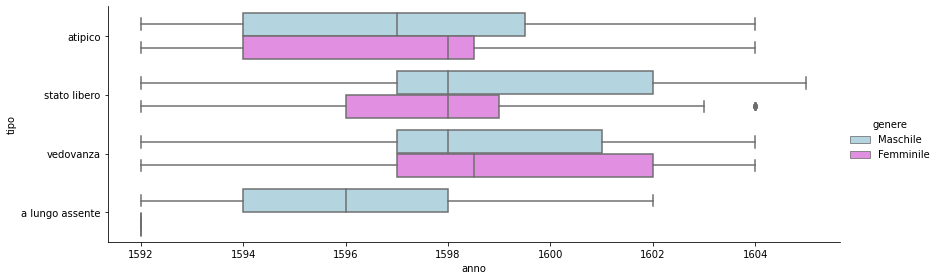

In [95]:
ax = sns.catplot(x="anno", y="tipo", hue="genere",

                    data=filtered_df, 
                    orient="h", height=4, aspect=3, kind="box",  palette=['lightblue','violet'])
# dodge=True,

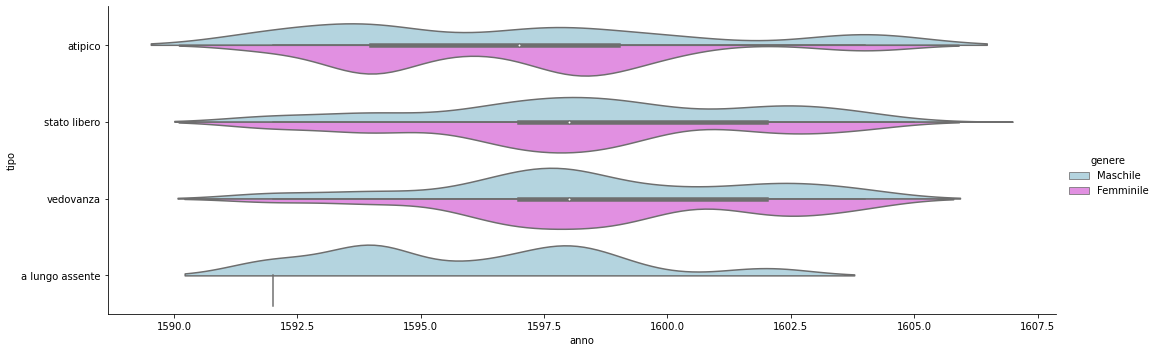

In [96]:
ax = sns.catplot(x="anno", y="tipo", hue="genere",  # hue="qualita_persona", genere
                    data=filtered_df, orient="h", height=5, aspect=3,
                kind="violin",  bw=.3, palette=['lightblue','violet'], split=True)
# dodge=True,

## Regrouper les _Processetti_ par type et age

The lines below explore the distribution of “age” at the moment of the processetto according to the different types of processetto (first chart).

In a second part, the different persons are grouped in age brackets of 5 years (lustro) in order to make the analysis more easily interpretable (second chart).

In [104]:
### Tableau de contingence age-type Processetto
# pour les personnes objet de l'enquête

X = "eta"  
Y = "tipo"

anno_tipo = df_result_list[(df_result_list['qualita_persona']=='richiedente')&(df_result_list['eta']>12)&(df_result_list['eta']<100)][[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
anno_tipo.iloc[1:20]

tipo,a lungo assente,atipico,stato libero,vedovanza
eta,,,,
15,0,0,3,0
16,0,0,10,0
17,0,0,13,0
18,2,0,27,0
19,1,2,55,0
20,0,1,91,0
21,2,1,97,0
22,0,1,110,0
23,2,1,93,0


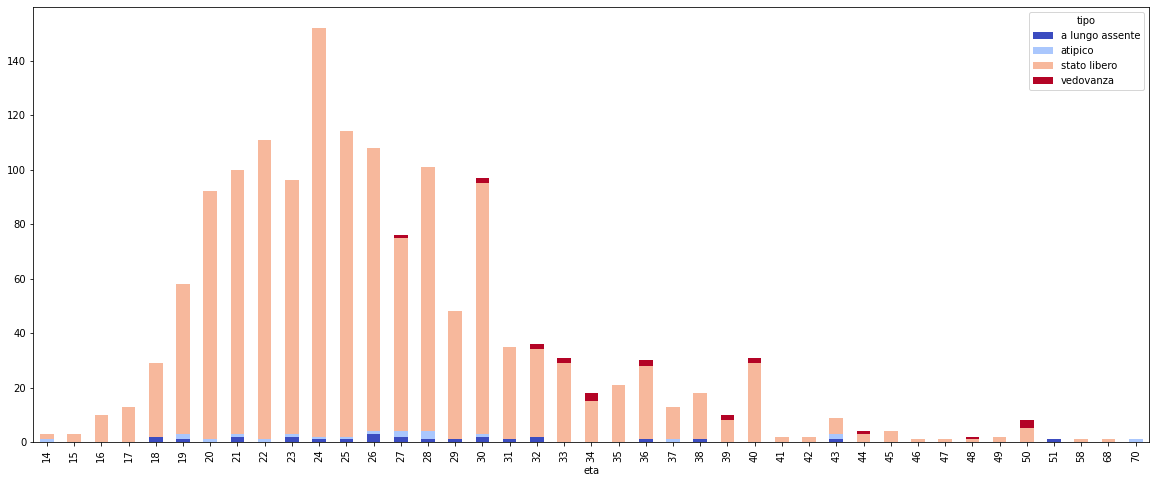

In [153]:
axis = anno_tipo.plot(kind="bar", stacked="true", figsize=(20,8), colormap="coolwarm")


In [106]:
### Créer la liste des périodes de 5 ans, i.e. la liste de la première année de chaque période
a5List = []
period = 5
d_start = 6
i = 0
a5List.append(d_start)

while i < 19:
    d_start = d_start + period
    a5List.append(d_start)
    i += 1

In [107]:
print(a5List[:2])
min(a5List), max(a5List)

[6, 11]


(6, 101)

In [108]:
df_result_list_lustres = df_result_list.copy(deep=True)
df_result_list_lustres['lustro'] = pd.cut(df_result_list_lustres['eta'], a5List, right=False)
# Inspection
df_result_list_lustres

,anno,qualita_persona,tipo,genere,eta,lustro
0,1592,testimone,atipico,Maschile,34,"[31.0, 36.0)"
1,1592,richiedente,atipico,Maschile,26,"[26.0, 31.0)"
2,1592,richiedente,stato libero,Maschile,25,"[21.0, 26.0)"
3,1592,richiedente,stato libero,Maschile,20,"[16.0, 21.0)"
4,1592,richiedente,stato libero,Maschile,26,"[26.0, 31.0)"
...,...,...,...,...,...,...
5486,1628,richiedente,stato libero,Femminile,0,NaN
5487,1628,testimone,stato libero,Maschile,39,"[36.0, 41.0)"
5488,1693,richiedente,stato libero,Maschile,117,NaN
5489,1693,testimone,stato libero,Maschile,126,NaN


In [109]:
### Transformer le code ajouté pour qu'il soit plus lisible
df_result_list_lustres['lustro'] = df_result_list_lustres['lustro'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))

In [110]:
df_result_list_lustres.head()

,anno,qualita_persona,tipo,genere,eta,lustro
0,1592,testimone,atipico,Maschile,34,31-36
1,1592,richiedente,atipico,Maschile,26,26-31
2,1592,richiedente,stato libero,Maschile,25,21-26
3,1592,richiedente,stato libero,Maschile,20,16-21
4,1592,richiedente,stato libero,Maschile,26,26-31


In [111]:
### Tableau de contingence lustres-typologie

X = "lustro"  
Y = "tipo"

lustro_tipo = df_result_list_lustres[(df_result_list['qualita_persona']=='richiedente')&(df_result_list_lustres['eta']>12)&(df_result_list_lustres['eta']<100)][[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
lustro_tipo.iloc[1:20]

tipo,a lungo assente,atipico,stato libero,vedovanza
lustro,,,,
16-21,3,3,196,0
21-26,6,5,562,0
26-31,9,7,411,3
31-36,3,0,131,7
36-41,2,1,93,6
41-46,1,2,17,1
46-51,0,0,10,4
51-56,1,0,0,0
56-61,0,0,1,0


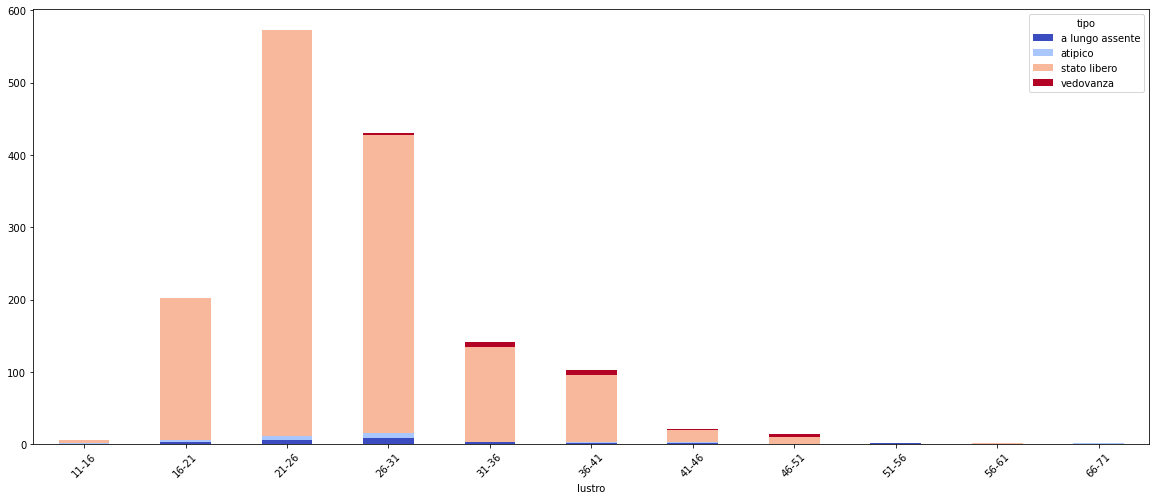

In [154]:
## https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/
axis = lustro_tipo.plot(kind="bar", stacked='true', figsize=(20,8), colormap="coolwarm")
xt = plt.xticks(rotation=45)

In [120]:
### Transformer les effectifs en fréquences
lustro_tipo_prop = lustro_tipo.apply(lambda x: x*100/sum(x), axis=1)

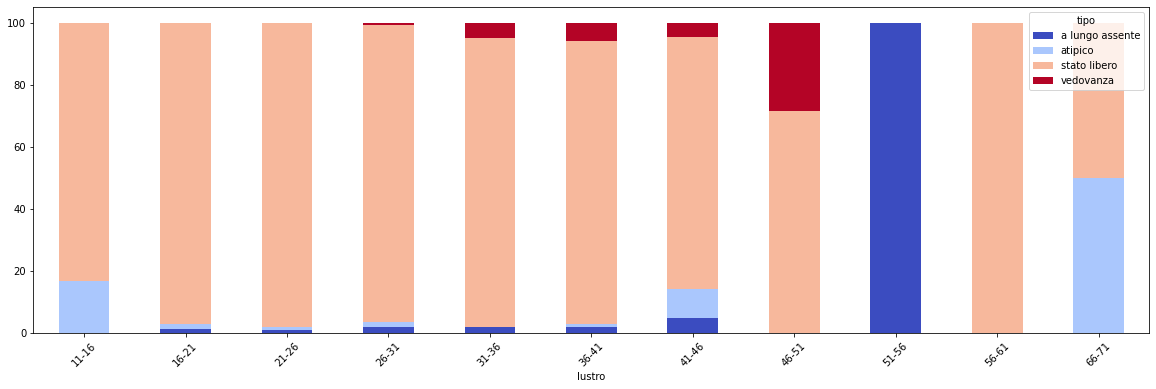

In [156]:
axis = lustro_tipo_prop.plot(kind="bar", stacked='true', figsize=(20,6), colormap="coolwarm")
xt = plt.xticks(rotation=45)

In [118]:
### Tableau de contingence lustres-typologie: femmes

X = "lustro"  
Y = "tipo"

lustro_tipo_f = df_result_list_lustres[(df_result_list['qualita_persona']=='richiedente')\
                        &(df_result_list_lustres['eta']>12)&(df_result_list_lustres['eta']<100)\
                        &(df_result_list_lustres['genere']=='Femminile')]\
                        [[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
lustro_tipo_f.iloc[1:20]

tipo,a lungo assente,atipico,stato libero,vedovanza
lustro,,,,
16-21,1,3,62,0
21-26,0,1,81,0
26-31,0,3,60,1
31-36,0,0,20,4
36-41,0,0,25,4
41-46,0,1,5,0
46-51,0,0,3,1


In [122]:
### Tableau de contingence lustres-typologie: hommes

X = "lustro"  
Y = "tipo"

lustro_tipo_m = df_result_list_lustres[(df_result_list['qualita_persona']=='richiedente')\
                        &(df_result_list_lustres['eta']>12)&(df_result_list_lustres['eta']<100)\
                        &(df_result_list_lustres['genere']=='Maschile')]\
                        [[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
lustro_tipo_m.iloc[1:20]

tipo,a lungo assente,atipico,stato libero,vedovanza
lustro,,,,
16-21,2,0,134,0
21-26,6,4,480,0
26-31,9,4,351,2
31-36,3,0,111,3
36-41,2,1,68,2
41-46,1,1,12,1
46-51,0,0,7,3
51-56,1,0,0,0
56-61,0,0,1,0


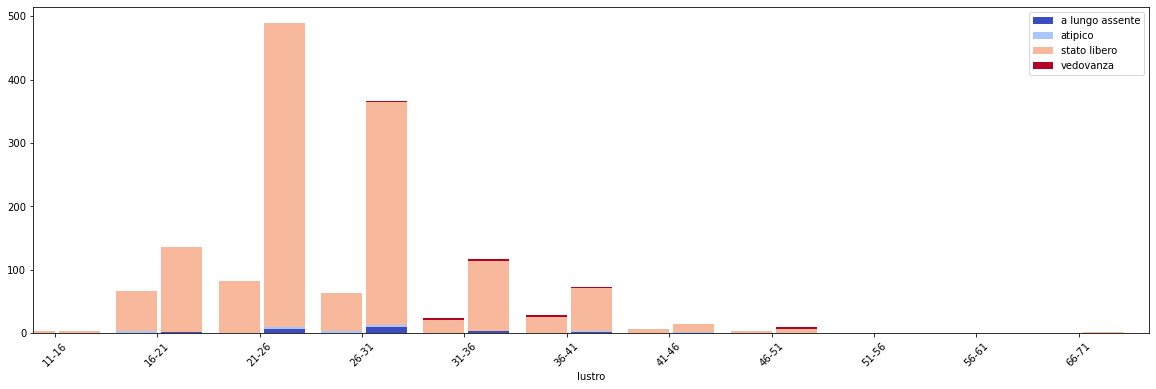

In [124]:
### Séparer et comparer les requérants hommes et femmes

# Première colonne de chaque groupe : femmes, seconde: hommes

##  https://stackoverflow.com/questions/39013425/multiple-stacked-bar-plot-with-pandas
## Voir aussi : https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars-with-python-pandas

fig, ax = plt.subplots(figsize=(20,6))

lustro_tipo_f.plot.bar(stacked=True, width=0.4, position=1, colormap="coolwarm", ax=ax) #, colormap="bwr" / RdGy , alpha=0.7)
lustro_tipo_m.plot.bar(stacked=True, width=0.4, position=-0.1, colormap="coolwarm", ax=ax) #, alpha=0.7)

# Fonction qui élimine les doubons dans la légende
legend_without_duplicate_labels(ax)

plt.xticks(rotation=45)
plt.show()

In [125]:
### Transformer les effectifs en fréquences
lustro_tipo_f_prop = lustro_tipo_f.apply(lambda x: x*100/sum(x), axis=1)
lustro_tipo_m_prop = lustro_tipo_m.apply(lambda x: x*100/sum(x), axis=1)

In [126]:
f = []
[f.append([i,'F']) for i,r in lustro_tipo_f.iterrows()]
df_f = pd.DataFrame(f)
df_f

,0,1
0,11-16,F
1,16-21,F
2,21-26,F
3,26-31,F
4,31-36,F
5,36-41,F
6,41-46,F
7,46-51,F


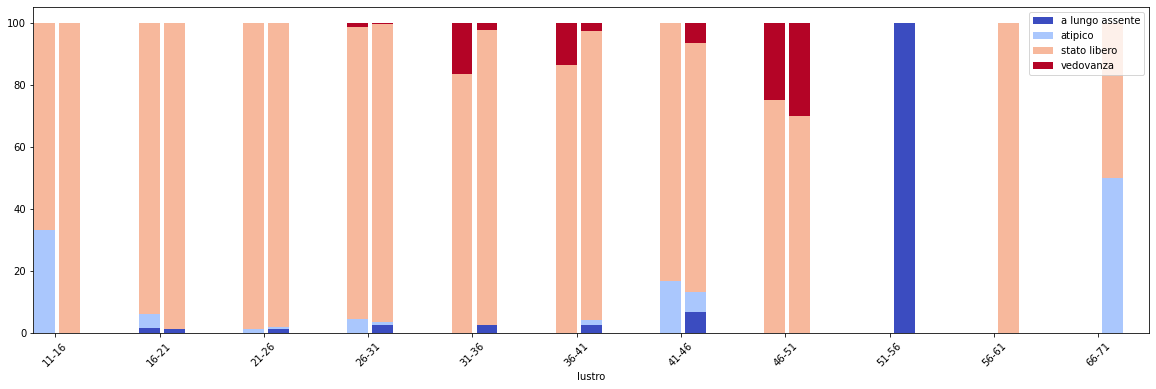

In [128]:
### Première colonne: femmes, seconde: hommes

fig, ax = plt.subplots(figsize=(20,6))
lustro_tipo_f_prop.plot.bar(stacked=True, width=0.2, position=1, colormap="coolwarm", ax=ax)
lustro_tipo_m_prop.plot.bar(stacked=True, width=0.2, position=-0.2, colormap="coolwarm", ax=ax)
plt.legend() # loc="upper center"

# Fonction qui élimine les doubons dans la légende
legend_without_duplicate_labels(ax)

xt = plt.xticks(rotation=45)
plt.show()

## Différence d'age

Inspecter la différence d'âge entre les requérants et les témoins

### Préparation des données

In [130]:
pl_df.iloc[55:60]

,id_persona,nome,anno_nascita,genere,luogo_origine,mestieri,numero_processetti,id_primo_processetto,anno_primo_processetto,tipo_primo_processetto,numero_testimonianze,id_prima_testimonianza,anno_prima_testimonianza,tipo_prima_testimonianza,date_unions,eta
55,749019,Antonio di Alterio Antonio Pizzoli (bergamasco...,1564.0,Maschile,Territorio di Bergamo(749027),fachin(749039),1,754435,1597.0,Stato libero di “foresto”,0,0,0.0,,NaN,33.0
56,749052,Giacomo di Pietro Roveda,1576.0,Maschile,Diocesi di Coira(749227)#Pontella(750696),galiner(766889),0,0,0.0,,1,749080,1598.0,Stato libero di “foresto”,NaN,22.0
57,749143,Pietro di Bartolomeo De Cobellis (bergamasco),1533.0,Maschile,Territorio di Bergamo(749027),impenditor(749130),0,0,0.0,,1,754435,1597.0,Stato libero di “foresto”,NaN,64.0
58,749208,Antonio di Giovanni Pietro De Recchialis (berg...,1559.0,Maschile,Territorio di Bergamo(749027),fachin(749039),0,0,0.0,,1,754435,1597.0,Stato libero di “foresto”,NaN,38.0
59,749635,Battista di Pietro Giuliano Pinzano (da Corden...,1570.0,Maschile,Cordenons(749648),,1,754466,1597.0,Stato libero di “foresto”,0,0,0.0,,NaN,27.0


In [131]:
#req = pl_df.iloc[50:70][(pl_df['numero_processetti']>0)&(pl_df['anno_nascita']>0)][['id_primo_processetto', 'anno_nascita']]
req = pl_df[(pl_df['numero_processetti']>0)&(pl_df['anno_nascita']>0)][['id_primo_processetto', 'anno_nascita']]
req.head()

,id_primo_processetto,anno_nascita
4,739330,1566.0
5,1083057,1567.0
6,745768,1572.0
7,1083384,1566.0
9,1083610,1570.0


In [132]:
tem = pl_df[(pl_df['numero_testimonianze']>0)&(pl_df['anno_nascita']>0)][['id_prima_testimonianza', 'anno_nascita']].rename(columns={'id_prima_testimonianza':'id_primo_processetto'})
tem.head()

,id_primo_processetto,anno_nascita
0,739330,1558.0
8,739330,1558.0
11,1084018,1563.0
20,911374,1566.0
27,747599,1548.0


In [133]:
m_pl_df = pd.merge(req, tem, how="left", on='id_primo_processetto')
m_pl_df.head()

,id_primo_processetto,anno_nascita_x,anno_nascita_y
0,739330,1566.0,1558.0
1,739330,1566.0,1558.0
2,1083057,1567.0,1546.0
3,1083057,1567.0,1558.0
4,745768,1572.0,1556.0


In [134]:
m_pl_df['diff_eta'] = m_pl_df['anno_nascita_x'] - m_pl_df['anno_nascita_y']
#m_pl_df['diff_eta'] = m_pl_df['diff_eta'].fillna(0)
m_pl_df.head()

,id_primo_processetto,anno_nascita_x,anno_nascita_y,diff_eta
0,739330,1566.0,1558.0,8.0
1,739330,1566.0,1558.0,8.0
2,1083057,1567.0,1546.0,21.0
3,1083057,1567.0,1558.0,9.0
4,745768,1572.0,1556.0,16.0


In [135]:
min(m_pl_df['diff_eta']), max(m_pl_df['diff_eta'])

(-401.0, 75.0)

### Analyse

In [136]:
m_pl_df[m_pl_df['diff_eta']>-60]['diff_eta'].describe()

count    3060.000000
mean       11.615033
std        13.798704
min       -43.000000
25%         1.000000
50%        10.000000
75%        20.000000
max        75.000000
Name: diff_eta, dtype: float64

In [137]:
d = pd.DataFrame(m_pl_df[m_pl_df['diff_eta']>-60].groupby('diff_eta').size())  #, columns=['diff_eta', 'effectif']).reset_index()
dr = d.rename(columns={0:'effectif'})
dr = dr.reset_index()
dr

,diff_eta,effectif
0,-43.0,1
1,-34.0,1
2,-30.0,1
3,-28.0,1
4,-27.0,1
...,...,...
86,62.0,1
87,64.0,1
88,65.0,2
89,71.0,1


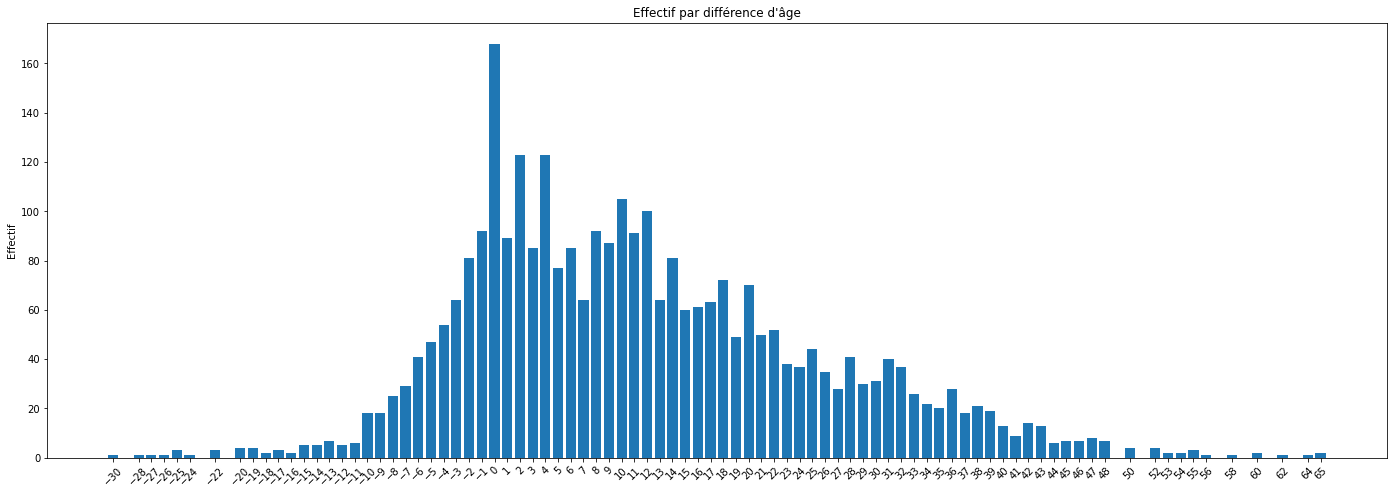

In [140]:
### Distribution par année

# Noter le filtre sur les valeurs extrèmes – elles sont exclues

objects = [int(l) for l in dr[dr['diff_eta'].between(-30,65)]['diff_eta']]
eff = [l for l in dr[dr['diff_eta'].between(-30,65)]['effectif']]

p1 = plt.bar(objects, eff)


plt.ylabel('Effectif')
plt.title("Effectif par différence d'âge")
plt.gcf().set_size_inches(24, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(objects,rotation=45)
plt.show()


# Professions, lieux d'origine: codage nécessaire

In [141]:
pl_df.iloc[55:60]

,id_persona,nome,anno_nascita,genere,luogo_origine,mestieri,numero_processetti,id_primo_processetto,anno_primo_processetto,tipo_primo_processetto,numero_testimonianze,id_prima_testimonianza,anno_prima_testimonianza,tipo_prima_testimonianza,date_unions,eta
55,749019,Antonio di Alterio Antonio Pizzoli (bergamasco...,1564.0,Maschile,Territorio di Bergamo(749027),fachin(749039),1,754435,1597.0,Stato libero di “foresto”,0,0,0.0,,NaN,33.0
56,749052,Giacomo di Pietro Roveda,1576.0,Maschile,Diocesi di Coira(749227)#Pontella(750696),galiner(766889),0,0,0.0,,1,749080,1598.0,Stato libero di “foresto”,NaN,22.0
57,749143,Pietro di Bartolomeo De Cobellis (bergamasco),1533.0,Maschile,Territorio di Bergamo(749027),impenditor(749130),0,0,0.0,,1,754435,1597.0,Stato libero di “foresto”,NaN,64.0
58,749208,Antonio di Giovanni Pietro De Recchialis (berg...,1559.0,Maschile,Territorio di Bergamo(749027),fachin(749039),0,0,0.0,,1,754435,1597.0,Stato libero di “foresto”,NaN,38.0
59,749635,Battista di Pietro Giuliano Pinzano (da Corden...,1570.0,Maschile,Cordenons(749648),,1,754466,1597.0,Stato libero di “foresto”,0,0,0.0,,NaN,27.0


In [157]:
### Lieux d'origine

d = pd.DataFrame(pl_df.groupby('luogo_origine').size(),columns=['effectif']).reset_index()
sd = d.sort_values(by='effectif', ascending = False)
sd.values.tolist()[:10]

[['', 655],
 ['Venezia IT(209678)', 478],
 ['Territorio di Bergamo(749027)', 140],
 ['Cadore(761036)', 99],
 ['Carnia(773870)', 69],
 ['Territorio di Vicenza(753775)', 64],
 ['Friuli(748393)', 62],
 ['Bergamo(999686)', 57],
 ['Territorio di Brescia(768454)', 53],
 ['Territorio di Milano(755887)', 50]]

In [158]:
### Professions

d = pd.DataFrame(pl_df.groupby('mestieri').size(),columns=['effectif']).reset_index()
sd = d.sort_values(by='effectif', ascending = False)
sd.values.tolist()[:10]

[['', 1263],
 ['mariner(747734)', 295],
 ['fachin(749039)', 237],
 ['tesser da panni da seda(762608)', 187],
 ['masser(748476)', 182],
 ['samitarius(759573)', 149],
 ['laner(750149)', 133],
 ['tesser da panni(753783)', 128],
 ['sartor(755657)', 103],
 ['barcariol(747742)', 99]]

# Préparation préalable à la mise 'à plat' du fichier 

Sont ici documentés les choix d'agrégation des données —cf. ci-dessus— effectués afin de pouvoir effectuer plus facilement les analyses

In [14]:
### Person
[(r.col_0.entity.pk_entity, r.col_0.entity.entity_label) for r in dm_r[0:1]]


[(81417, 'Tommaso di Lorenzo Spilman (tedesco)')]

In [81]:
### Gender
# La première entrée est retenue (normalement il n'y en a pas plus)
[r.col_1.entities[0].entity_label if r.col_1 else 'missing' for r in dm_r[0:1]]

['Maschile']

In [83]:
### Origin
# Plusieurs origines son possibles pour une même personne : laquelle retenir ?
[[p.entity_label + '('+ str(p.pk_entity) +')' for p in r.col_5.entities] for r in dm_r[10:20]]

[['Modena(1083842)'],
 ['Costae diocesis Adriensis(1083910)'],
 [],
 ['Zurbao (1084309)'],
 ['Territorio di Milano(755887)', 'Rancio (1084720)'],
 ['Territorio di Udine(759336)'],
 ['Territorio di Brescia(768454)'],
 ['Ballobia (1084355)', 'Dioecesis Palentina(1084368)'],
 [],
 []]

In [84]:
### Occupation
# Plusieurs métiers sont possibles pour la même personne
[[p.entity_label + '('+ str(p.pk_entity) +')' for p in r.col_4.entities] for r in dm_r[40:50]]

[['mercante de panni (763128)'],
 ['boter(752920)'],
 [],
 ['portador da vin(748738)'],
 [],
 ['mariner(747734)', 'servir in bottega de luganegher (754028)'],
 ['pestriner(749677)', 'latter(749702)'],
 ['verghezin (748828)'],
 ['verghezin (748828)'],
 ['verghezin (748828)']]

In [ ]:
### Occupation
# Plusieurs métiers sont possibles pour la même personne
t1 = pd.DataFrame([[p.entity_label + '('+ str(p.pk_entity) +')' for p in r.col_4.entities][0] for r in dm_r if r.col_4.entities], columns=['occupation'])
t2 = t1.groupby('occupation').size()
t3 = t2.sort_values(ascending = False)
pd.DataFrame(t3,columns=['effectif']).reset_index().iloc[:50]

In [310]:
### Année de naissance
# Plusieurs années sont renseignées (ad quem, a quo) : la moyenne arrondie est retenue
for r in dm_r[36:40]:
    print(r.col_0.entity.pk_entity)
    values = []
    for v in r.col_2['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
    if len(values) > 1:
        print(int(round(np.rint(np.mean(values)))), values)
    elif len(values) > 0:    
        print(values[0])
    else:
        print(None)
    print('-----')       

747846
1527
-----
748299
1578 [1577, 1579]
-----
748322
1564 [1562, 1567]
-----
748378
1537
-----


In [ ]:
### Année processetto
for r in dm_r[50:60]:
    print(r.col_0.entity.pk_entity)
    values = []
    for v in r.col_7['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
    if len(values) > 1:
        print(int(round(np.rint(np.mean(values)))), values)
    elif len(values) > 0:    
        print(values[0])
    else:
        print(None)
    print('-----')       

In [ ]:
### Années union
# Plusieurs années sont renseignées (ad quem, a quo) : la moyenne arrondie est retenue
for r in dm_r[:500]:
    
    values = []
    for v in r.col_13['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        print(r.col_0.entity.pk_entity)
        print(int(round(np.rint(np.mean(values)))), values)
        print('-----')       
    elif len(values) > 0:  
        print(r.col_0.entity.pk_entity)
        print(values[0])
        print('-----')       
    else:
        pass
        # print(r.col_0.entity.pk_entity)
        # print(None)
        # print('-----')       

### Bouts de code à ranger ou éliminer

In [113]:
### Transformation en dictionnaire 
pl_dict = pl_df.to_dict('records')

In [358]:
str(pl_dict)[:1000]

"[{'id_persona': 81417, 'nome': 'Tommaso di Lorenzo Spilman (tedesco)', 'anno_nascita': 1558.0, 'genere': 'Maschile', 'luogo_origine': 'Alemania(753623)', 'mestieri': '', 'numero_processetti': 0, 'id_primo_processetto': 0, 'anno_primo_processetto': nan, 'tipo_primo_processetto': '', 'numero_testimonianze': 1, 'id_prima_testimonianza': 739330, 'anno_prima_testimonianza': 1592.0, 'tipo_prima_testimonianza': 'Stato libero di “foresto” #Processetto atipico ', 'date_unions': nan}, {'id_persona': 81461, 'nome': 'Gieremia Vais', 'anno_nascita': nan, 'genere': 'Maschile', 'luogo_origine': '', 'mestieri': '', 'numero_processetti': 0, 'id_primo_processetto': 0, 'anno_primo_processetto': nan, 'tipo_primo_processetto': '', 'numero_testimonianze': 0, 'id_prima_testimonianza': 0, 'anno_prima_testimonianza': nan, 'tipo_prima_testimonianza': '', 'date_unions': nan}, {'id_persona': 81648, 'nome': 'Limoletti, Domenico', 'anno_nascita': nan, 'genere': 'Maschile', 'luogo_origine': '', 'mestieri': '', 'num

### Gender

In [13]:
[r.col_1.entities[0].entity_label if r.col_1 else 'missing' for r in dm_r[0:5]]

['Maschile', 'Maschile', 'Maschile', 'Maschile', 'Maschile']

In [14]:
### gender list -> gl
gl = [r.col_1.entities[0].entity_label if r.col_1.entities else 'missing' for r in dm_r]
print(gl[101:107])
len(gl)

['Maschile', 'Maschile', 'Maschile', 'Maschile', 'Maschile', 'Maschile']


5608

In [15]:
D = dict(Counter(gl))
print(D)
len(D)

{'Maschile': 4935, 'Femminile': 636, 'missing': 37}


3

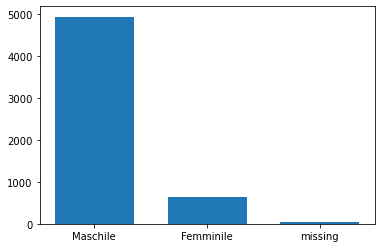

In [16]:
plt.bar(range(len(D)), list(D.values()), align='center', width=0.7)
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

## Age by category

In [ ]:
# [pprint.pprint(r) for r in rows[50:100]]

In [ ]:
def get_entities_JD(entities):
    result = []
    for e in entities:
        if e.time_span.p82.julianDay:
            result.append({'pk_teen' : e.pk_entity, 'JD' : e.time_span.p82.julianDay})
        elif e.time_span.p81a.julianDay:
            result.append({'pk_teen' : e.pk_entity, 'JD' : e.time_span.p81a.julianDay})
        elif e.time_span.p82a.julianDay:
            result.append({'pk_teen' : e.pk_entity, 'JD' : e.time_span.p82a.julianDay})
        else:
            result.append(None)

    return result

def get_entities_label(entities):
    result = []
    for e in entities:
        if e.entity_label:
            result.append(e.entity_label)
        else:
            result.append(None)

    return result

In [ ]:
ageOccupationProcessetto = []
for r in dm_r: #[299:303]:
    
    ## person identifier
    pk_entity = r.col_0.entity.pk_entity

    ## births
    birthsJD = get_entities_JD(r.col_3.entities)
    
    ## occupations, join the labels    
    occupations = ','.join([e.entity_label for e in r.col_10.entities])
    
    ## occupations, list 
    occupations_l = get_entities_label(r.col_10.entities)
    
    ## enquiries, get begin date
    enquiries = get_entities_JD(r.col_11.entities)

    ## witnesses, get begin date
    witnesses =  get_entities_JD(r.col_12.entities)
                
    ageOccupationProcessetto.append([pk_entity, birthsJD, occupations_l, enquiries, witnesses])               
    
    
    


In [ ]:
pprint.pprint(ageOccupationProcessetto[50:100])

In [ ]:
### age au moment du processetto et métier
dateBirthEnquiryOccupation = []
for l in ageOccupationProcessetto: #[50:70]:
    if l[1] and l[3]:
        if l[1][0] and l[3][0]:
            d = [jd.jd2jcal((l[1][0]['JD']),0)[0:3],jd.jd2jcal((l[3][0]['JD']),0)[0:3]]
            if l[2]:
                dateBirthEnquiryOccupation.append(d + [l[2]])
            else:    
                dateBirthEnquiryOccupation.append(d )
    else:
        dateBirthEnquiryOccupation.append(None)

    

In [ ]:
ages = [(y[1][0] - y[0][0]) for y in dateBirthEnquiryOccupation if y]
print(ages[:5])

In [ ]:
s_ages = pd.Series(ages)
s_ages.describe()

In [ ]:
std = s_ages.sort_values()
type(std)

In [ ]:
# agesCount
agesCount = pd.DataFrame(s_ages, columns=['column']).groupby(['column']).size()
# print(type(agesCount))
# agesCount.index

In [ ]:
ax = agesCount.plot.bar(x='lab', y='val', rot=70, figsize=(20,5))